In [2]:
!pip uninstall tensorflow --yes

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0


In [3]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 3.0 MB 55.2 MB/s 
     |████████████████████████████████| 454 kB 47.5 MB/s 
     |████████████████████████████████| 2.9 MB 67.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0


In [4]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.utils import class_weight

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
GPU is available


In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
import joblib
import gc
#import segmentation_models as sm

In [6]:
os.environ['KAGGLE_USERNAME'] = "sanjanav98"
os.environ['KAGGLE_KEY'] = "2bb32d3324e753a524b072e9775b3e7a"

In [7]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:11<00:00, 129MB/s]
100% 1.03G/1.03G [00:11<00:00, 99.9MB/s]


In [8]:
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [9]:
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
1,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
2,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
4,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [10]:
raw_data.shape

(20, 4)

In [11]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [12]:
all_points1 = []
all_points2 = []

In [13]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 

        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [14]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

In [15]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

In [16]:
cts = []
lungs = []
infections = []

In [17]:
img_size = 512

In [18]:
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [19]:
len(infections)/len(cts)

1.0

In [20]:
new_dim = 224

In [21]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)

In [22]:
cts = np.array(cts)
infections = np.array(infections)

In [23]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [24]:
cts = cts/255
infections = infections/255

In [25]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(cts, infections, test_size=0.3, random_state=42)

In [27]:
print(x_train.shape, x_valid.shape)

(1478, 224, 224, 1) (634, 224, 224, 1)


In [28]:
inputs = Input((new_dim, new_dim, 1))
# s = Lambda(lambda x: x / 255) (inputs)

# def mish(inputs):
#     return inputs * tf.math.tanh(tf.math.softplus(inputs))
    
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [29]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [30]:
from tensorflow.keras.losses import binary_crossentropy
def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [31]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=bce_dice_loss,
              metrics=[dice_coeff])

In [33]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [34]:
model.fit(
    x=x_train, y=y_train, batch_size=32, epochs=80, verbose=1,callbacks=[checkpoint])


Epoch 1/80
47/47 [==============================] - ETA: 0s - loss: 0.3964 - dice_coeff: 0.3971
Epoch 00001: loss improved from inf to 0.39637, saving model to best_model.hdf5
47/47 [==============================] - 24s 502ms/step - loss: 0.3964 - dice_coeff: 0.3971
Epoch 2/80
47/47 [==============================] - ETA: 0s - loss: 0.2286 - dice_coeff: 0.6546
Epoch 00002: loss improved from 0.39637 to 0.22855, saving model to best_model.hdf5
47/47 [==============================] - 22s 465ms/step - loss: 0.2286 - dice_coeff: 0.6546
Epoch 3/80
47/47 [==============================] - ETA: 0s - loss: 0.1852 - dice_coeff: 0.7223
Epoch 00003: loss improved from 0.22855 to 0.18520, saving model to best_model.hdf5
47/47 [==============================] - 22s 470ms/step - loss: 0.1852 - dice_coeff: 0.7223
Epoch 4/80
47/47 [==============================] - ETA: 0s - loss: 0.1578 - dice_coeff: 0.7595
Epoch 00004: loss improved from 0.18520 to 0.15776, saving model to best_model.hdf5
47/47 [=

In [35]:
model.load_weights('best_model.hdf5')

In [36]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

20/20 [==============================] - 5s 243ms/step - loss: 0.0965 - dice_coeff: 0.8710
test loss, test dice coefficient: [0.09647680819034576, 0.8710162043571472]


In [37]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()

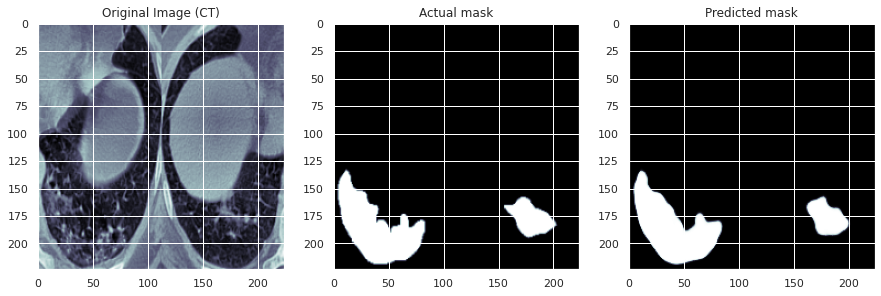

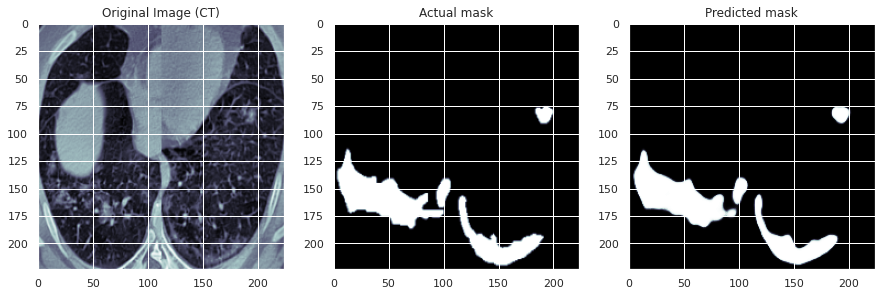

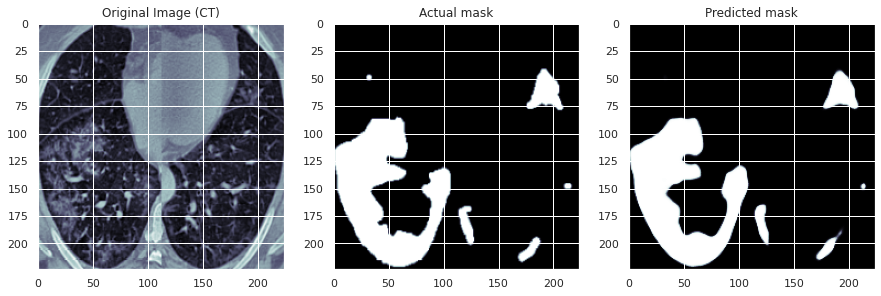

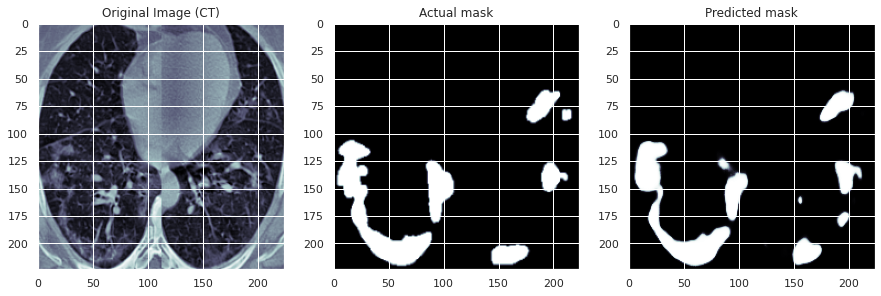

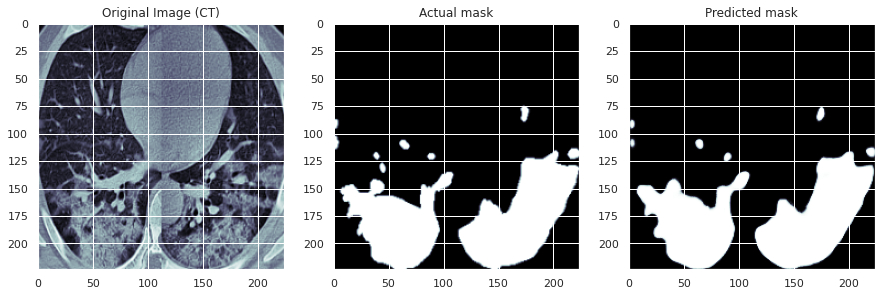

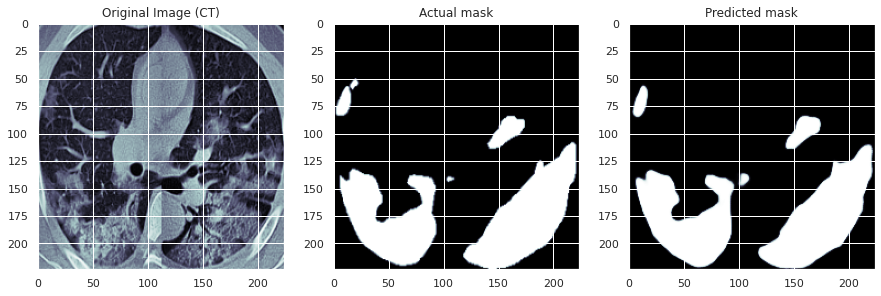

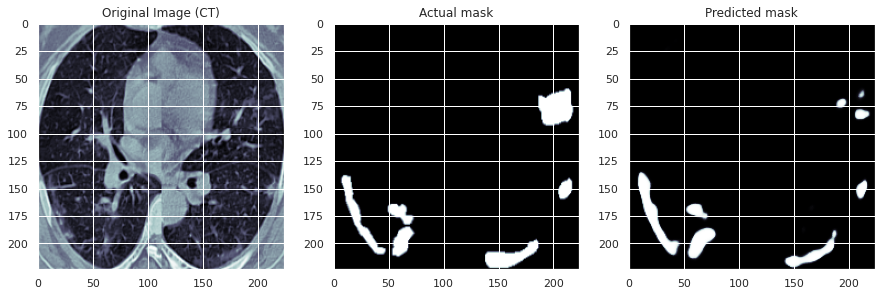

In [38]:
for i in [40,50,60,70, 355, 380, 100]:
    compare_actual_and_predicted(i)